In [1]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from utils_libs import *

import pickle

# ----- Contribution uncertainty

In [1]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp


def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])


real_l, real_r = 30, 250


# --- ground truth data

loc = 50
scale = 75


# normalized boundary
a = (real_l - loc)/scale
b = (real_r - loc)/scale

# Generate some data to work with.
r = truncnorm.rvs(a, 
                  b, 
                  loc = loc, 
                  scale = scale, 
                  size = 10000)

# --- fit

loc_guess = 30
scale_guess = 90

l_guess = (real_l - loc_guess)/scale_guess
r_guess = (real_r - loc_guess)/scale_guess

par = fmin_slsqp(func, 
                 [l_guess, r_guess, loc_guess, scale_guess], 
                 f_eqcons = constraint, 
                 args = (r, real_l, real_r),
                 iprint = False, 
                 iter = 1000)


print(p0)
print(par)

NameError: name 'p0' is not defined

In [66]:
[a_guess, b_guess, loc_guess, scale_guess]

([0.0, 2.4444444444444446, 30, 90],)

In [71]:
print(p0, par)

[0.0, 2.4444444444444446, 30, 90] [-0.31095205  2.70063449 52.71541923 73.05119655]


In [50]:
par[0]*par[-1] + par[-2]

30.00000010552779

In [51]:
par[1]*par[-1] + par[-2]

249.9999999596968

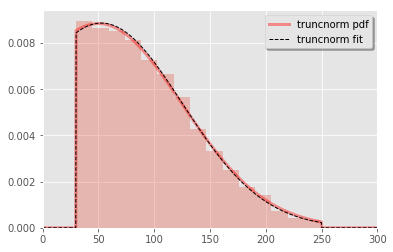

In [43]:

import matplotlib.pyplot as plt

xmin = 0
xmax = 300
x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, truncnorm.pdf(x, a, b, loc=loc, scale=scale),
        'r-', lw=3, alpha=0.4, label='truncnorm pdf')
ax.plot(x, truncnorm.pdf(x, *par),
        'k--', lw=1, alpha=1.0, label='truncnorm fit')
ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.xlim(xmin, xmax)
plt.grid(True)

plt.show()

In [26]:
a = [[1, ['a']], [2, ['b']], [3, ['c']]]


tmpmin = min(a, key = lambda x: x[0])
print(tmpmin)

tmpidx = a.index(tmpmin)

print(tmpidx)

[1, ['a']]
0


In [32]:
from utils_training import *

para_hpara_range = [[0.001, 0.001], [16, 80], [1e-7, 0.1]]
para_hpara_n_trial = 15

hpara_generator = hyper_para_random_search(para_hpara_range, 
                                              para_hpara_n_trial)

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)


AttributeError: 'hyper_para_random_search' object has no attribute 'hpara_trial'

In [29]:
from utils_training import *


para_lr_range = [0.001, ]
para_batch_range = [64, 32, 16, 80]
para_l2_range = [1e-7, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

hpara_generator = hpara_grid_search([para_lr_range, para_batch_range, para_l2_range])

tmp_hpara = hpara_generator.hpara_trial()
cnt = 0

while tmp_hpara != None:
    
    print(tmp_hpara)
    
    tmp_hpara = hpara_generator.hpara_trial()
    
    cnt += 1
    
print(cnt)
    

NameError: name 'hpara_grid_search' is not defined

In [25]:
t = np.array([2, 3])
t = np.append(t, [4])
print(t)

[2 3 4]


# ----- Results Analysis

In [2]:
def mape(y, 
         yhat):
    
    tmp_list = []
    
    for idx, val in enumerate(y):
        
        if abs(val) > 1e-5:
            tmp_list.append(abs(1.0*(yhat[idx]-val)/val))
    
    return np.mean(tmp_list)

def mae(y, 
        yhat):
    
    return np.mean(np.abs(np.asarray(y) - np.asarray(yhat)))
    
def rmse(y, 
         yhat):
    
    return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))


def rmse_mae_quantiles(target, 
                       pred, 
                       q):
    
    # q = number of quantiles
    
    x_sort = sorted(list(target))

    quant_val = [x_sort[i*int(len(x_sort)/q)] for i in range(1, q)]
    quant_val.append(max(x_sort)+1)

    sq_error_quant = [0 for _ in quant_val]
    abs_error_quant = [0 for _ in quant_val]
    abs_per_error_quant = [0 for _ in quant_val]
    
    num_quant = [0 for x in quant_val]
    
    num_mape_quant = [0 for x in quant_val]
    
    for i in range(1, len(x_sort)):
        
        tmp_vol = target[i]
        tmp_resi = target[i] - pred[i]
        
        q_idx = list(map(lambda j: j>tmp_vol, quant_val)).index(True)   
        
        sq_error_quant[q_idx] += tmp_resi**2
        abs_error_quant[q_idx] += abs(tmp_resi)
        num_quant[q_idx]+=1
        
        if abs(tmp_vol)>1e-5:
            
            abs_per_error_quant[q_idx] += abs(1.0*tmp_resi/tmp_vol)
            num_mape_quant[q_idx] += 1
        
        
    rmse_quantiles = [sqrt(sq_error_quant[j]/num_quant[j]) for j in range(0, len(quant_val))] 
    mae_quantiles = [abs_error_quant[j]/num_quant[j] for j in range(0, len(quant_val))] 
    
    mape_quantiles = [abs_per_error_quant[j]/num_mape_quant[j] for j in range(0, len(quant_val))] 
    
    return rmse_quantiles, mae_quantiles, mape_quantiles, quant_val

def result_plot(y, 
                path_res, 
                plot_l, 
                plot_r, 
                plot_title):
    
    py = pickle.load(open(path_res + ".p", "rb"), \
                     encoding='latin1')

    py_mean = py[0]
    py_var = py[1]
    
    print(np.shape(ts_y))
    #print(np.shape(py))

    num = len(ts_y)
    print("MAE", mae(ts_y, py_mean))
    print("RMSE", rmse(ts_y, py_mean))
    
#   -- mean  
    fig, ax = plt.subplots(figsize=(15,8));
    
    ax.plot(range(plot_l, plot_r), ts_y[plot_l: plot_r], label = 'truth',  marker='o');
    ax.plot(range(plot_l, plot_r), py_mean[plot_l: plot_r], label = 'prediction',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- variance
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), py_var[plot_l: plot_r], label = 'volatility',  marker='o');
    
    ax.set_title(plot_title)
    ax.legend()
    
#   -- histogram
    fig, ax = plt.subplots();

    ax.hist(py_mean, 2000);
    ax.set_xlim([-10, 50])
    ax.set_title(plot_title)
    
#   -- quantial conditional
    rmse_quantiles, mae_quantiles, mape_quantiles, quant_val = rmse_mae_quantiles(np.squeeze(ts_y), 
                                                                                  np.squeeze(py_mean), 
                                                                                  10)
    
    print("Quantiles", quant_val, '\n')
    
    print("  RMSE", rmse_quantiles)
    print("  MAE", mae_quantiles)
    print("  MAPE", mape_quantiles)
    

def plot(py, y, plot_l, plot_r):
    
    # [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]

    mean = py[0]
    total_v = np.sqrt(py[1])

    vol = np.sqrt(py[2])
    unc = np.sqrt(py[3])
    
    mean_low = mean - 3.0*unc
    mean_up = mean + 3.0*unc
    
    gate = py[4]
    gate_std = np.sqrt(py[5])
    
    print("gate shape: ", np.shape(gate), np.shape(py[6]))
    num_src = np.shape(gate)[1]
    
    # -- cross check

    np.shape(mean)
    y = np.asarray(np.squeeze(y))

    print(np.shape(mean), np.shape(y)) 
    print("cross check RMSE: ", np.sqrt(np.mean((y - mean)**2)), mae(y, mean) )
    
    
    src_dict = {0:"local trans.", 1:"external trans.", 2:"local order book", 3:"auto"}
#     src_dict = { 0:"local trans.", 1:"external trans.", 2:"local order book"  }

    # -- mean and uncertainty
    
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), y[plot_l: plot_r], label = 'truth',  marker='o', color = 'k', alpha = 0.4);
    ax.plot(range(plot_l, plot_r), mean[plot_l: plot_r], label = 'prediction',  marker='o', color = 'b', alpha = 0.4);
    ax.fill_between(range(plot_l, plot_r), mean_low[plot_l: plot_r], mean_up[plot_l: plot_r], 
                color = '#539caf', alpha = 0.4, label = '95% CI')

    ax.set_title("Predicted mean plus confidence interval");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.legend();
  
    #  -- Contribution of different sources with confidence interval
    fig, ax = plt.subplots(figsize=(15, 5));

    X = range(plot_l, plot_r)

    for tmp_src in range(num_src):
        tmp_y = [i[tmp_src] for i in gate[plot_l: plot_r]]
        tmp_yerr = [2*i[tmp_src] for i in gate_std[plot_l: plot_r]]
    
        ax.errorbar(X, tmp_y, yerr = tmp_yerr, marker='o', label = src_dict[tmp_src], capsize = 3);
    
    ax.legend();
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.set_title("Contribution of different sources with confidence interval");

    
#     # -- vol
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), vol[plot_l: plot_r], label = 'volatility',  marker='o', alpha=.3, color = 'g');

    ax.set_title("Volatility");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.set_ylim(20, 120);

    # -- uncertainty
    fig, ax = plt.subplots(figsize=(15,5));
    
    ax.plot(range(plot_l, plot_r), unc[plot_l: plot_r], label = 'uncertainty',  marker='o', alpha=.3, color = 'b');

    ax.set_title("Uncertainty on predicted mean");
    ax.set_xlabel("Time");
    ax.set_ylabel("Value");
    ax.set_ylim(0, 50);

# # -- gate

# fig, ax = plt.subplots(figsize=(15,5));

# X = range(plot_l, plot_r)

# cumu = [0.0 for j in range(plot_l, plot_r)]

# src_dict = { 0:"local trans.", 1:"external trans.", 2:"local order book"  }

# for tmp_src in range(num_src):
    
#     tmp_gate = [i[tmp_src] for i in gate[plot_l: plot_r]]
#     tmp_cumu = cumu + np.asarray(tmp_gate)
    
#     ax.plot(X, tmp_cumu, alpha=.5, label = src_dict[tmp_src]);
#     ax.fill_between(X, cumu, tmp_cumu, alpha=.5);
    
#     cumu = tmp_cumu

# ax.legend();
# ax.set_title("Contribution of different sources");
# ax.set_xlabel("Time");
# ax.set_ylabel("Value");



In [3]:
from utils_training import *


path_data = "../dataset/bitcoin/double_trx_ob_tar5_len10/"

ts_dta = pickle.load(open(path_data + 'test.p', "rb"), 
                     encoding = 'latin1')

ts_x, ts_y = data_reshape(ts_dta,
                          bool_target_seperate = True)


tmpx = data_padding_x(ts_x, 
                      num_src = len(ts_x))
print(np.shape(tmpx))

(6870, 9, 6)
(6870, 9, 7)
(6870, 9, 8)
(6870, 9, 1)
(4, 6870, 9, 8)


gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.35339397678044 33.765287799222286


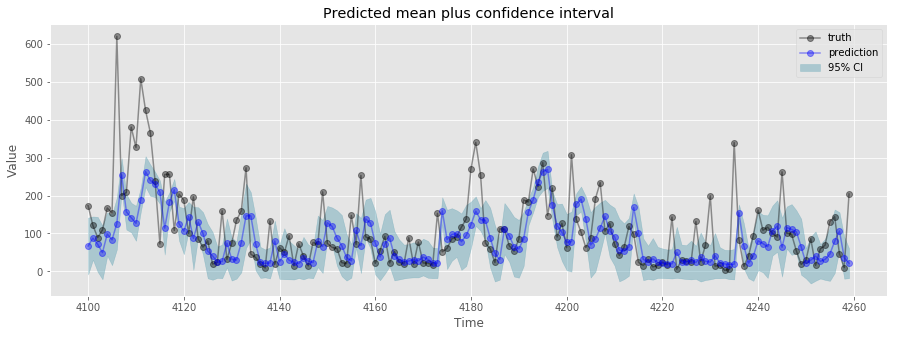

In [4]:

path_res = "../results/mixture_tar5_len10_ensemble_vol_unc/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 4100, 
     plot_r = 4260)

gate shape:  (6870, 3) (20, 6870, 3)
(6870,) (6870,)
cross check RMSE:  64.30856969414464 33.87231588392612


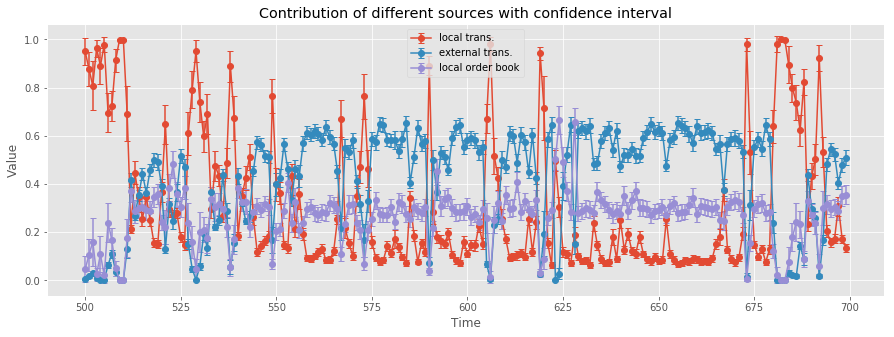

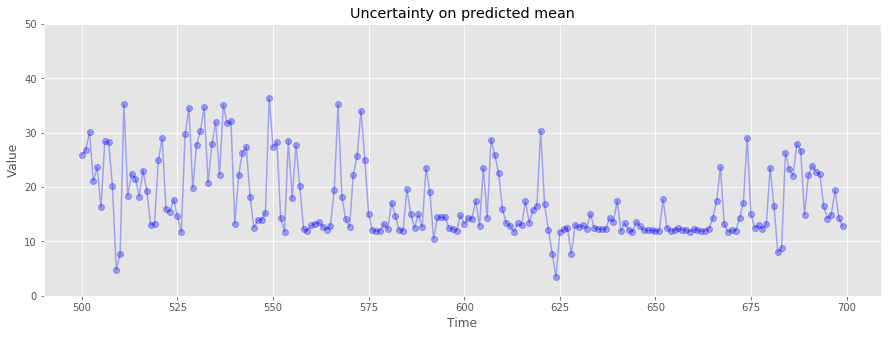

In [11]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_20/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 500, 
     plot_r = 700)

In [10]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_40/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 500, 
     plot_r = 700)

gate shape:  (6870, 3) (40, 6870, 3)
(6870,) (6870,)
cross check RMSE:  64.74958800884316 33.58317882895924


gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.56007453899775 33.327456802058805


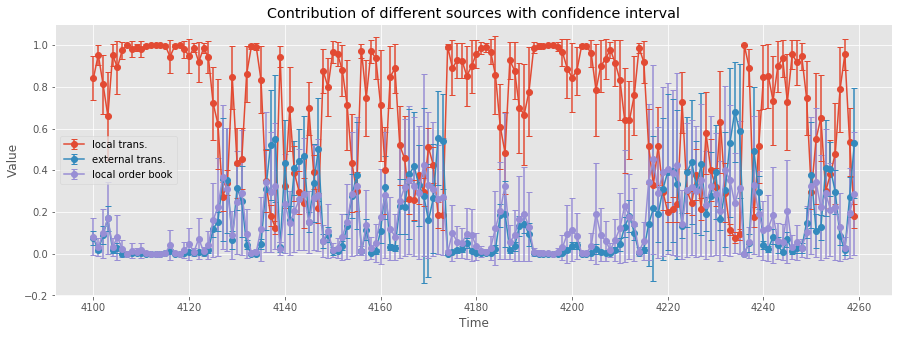

In [6]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 4100, 
     plot_r = 4260)

gate shape:  (6870, 4) (60, 6870, 4)
(6870,) (6870,)
cross check RMSE:  65.40807011726636 34.03804467219629


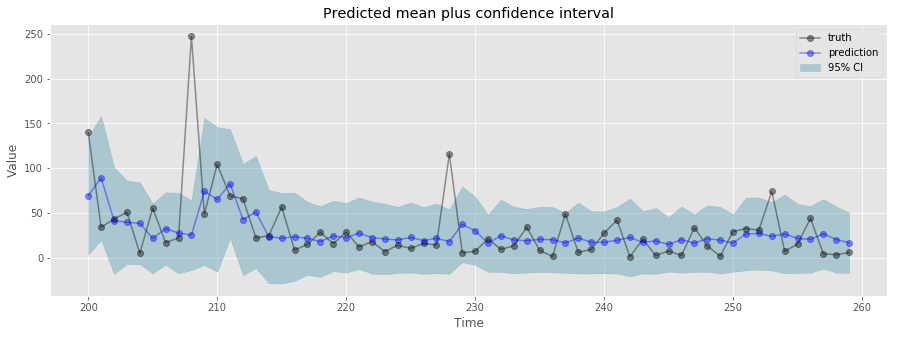

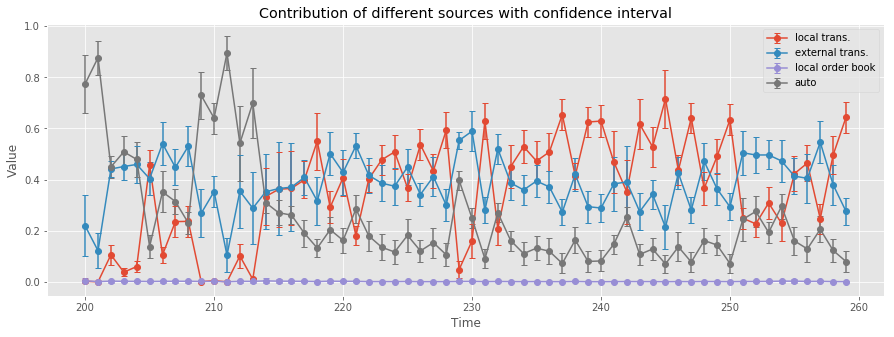

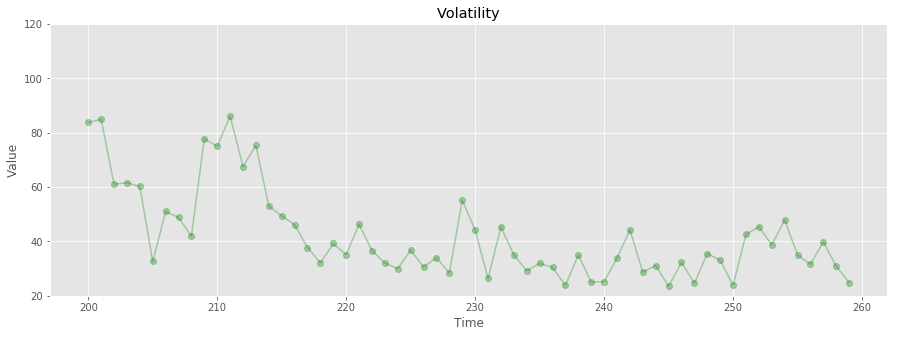

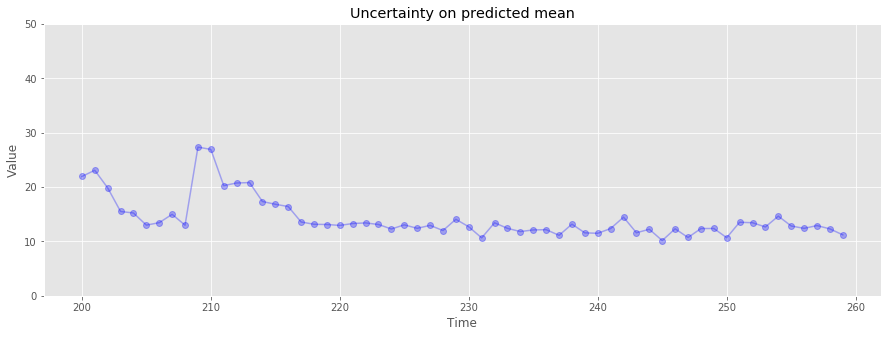

In [12]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60_4src_order/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 200, 
     plot_r = 260)

gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.56007453899775 33.327456802058805


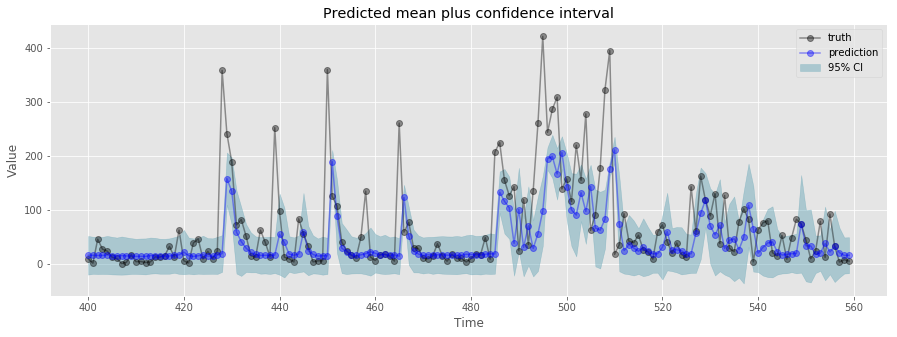

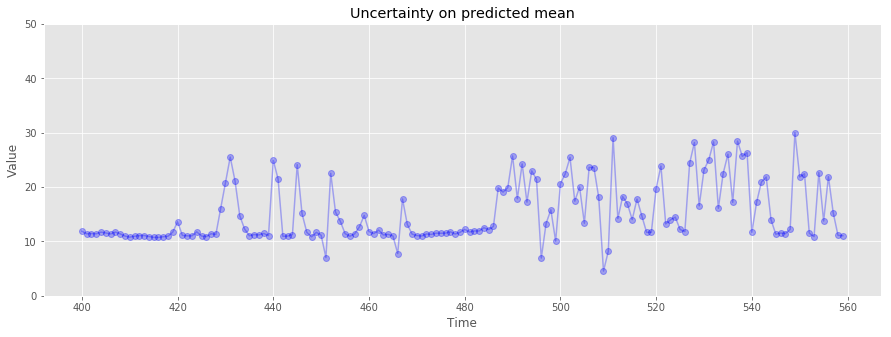

In [13]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60_3src/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py, 
     y = ts_y,
     plot_l = 400, 
     plot_r = 560)

gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  63.804352807101026 34.83059885344441


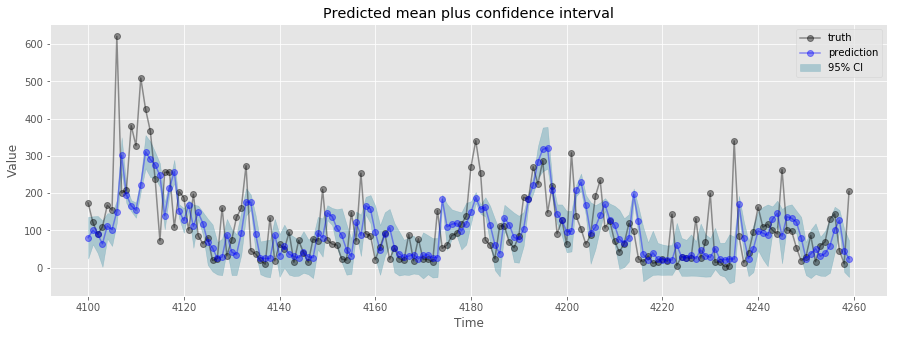

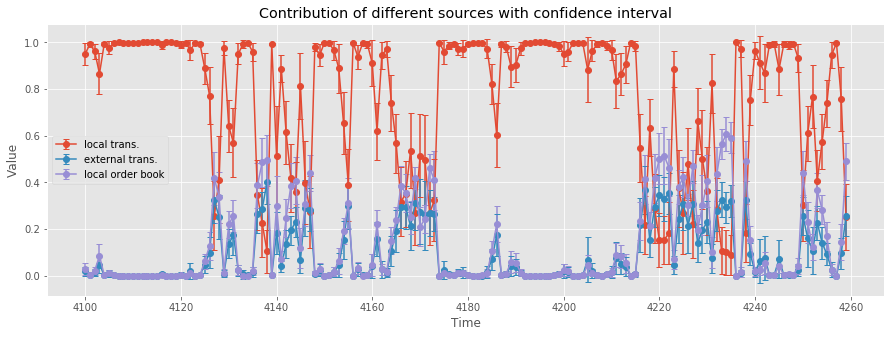

In [71]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60_aug_20per/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py,
     y = ts_y,
     plot_l = 4100,
     plot_r = 4260)

In [72]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60_aug_30per/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py,
     y = ts_y,
     plot_l = 4100,
     plot_r = 4260)

gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  63.573881748816525 35.58675473617753


gate shape:  (6870, 3) (60, 6870, 3)
(6870,) (6870,)
cross check RMSE:  65.55693251932803 33.326137324747776


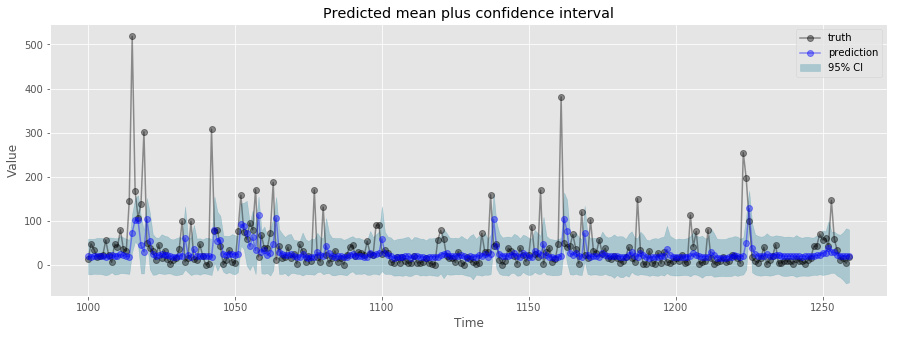

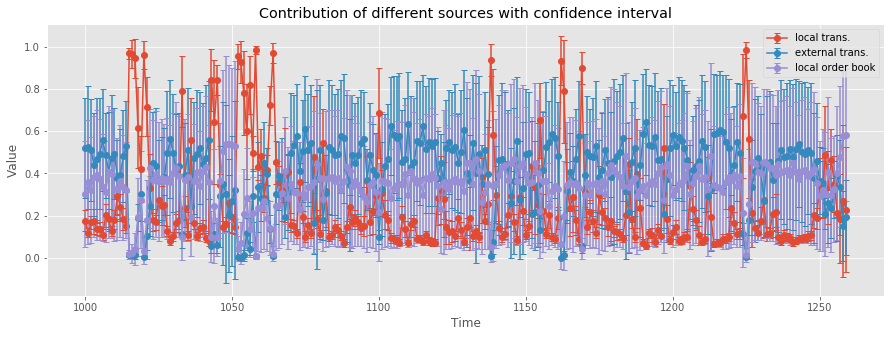

In [17]:
path_res = "../results/mixture_tar5_len10_ensemble_vol_unc_60_best_epoch/"
py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')

# [bayes_mean, bayes_total_var, bayes_vola, bayes_unc, bayes_gate_src, bayes_gate_src_var, g_src_sample]
list(zip([py[1], py[2], py[3]]))

plot(py,
     y = ts_y,
     plot_l = 1000,
     plot_r = 1260)

# -----

In [ ]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp

import matplotlib.pyplot as plt


def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)


def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])


xa, xb = 30, 250 
loc = 50
scale = 75

a = (xa - loc)/scale
b = (xb - loc)/scale

# Generate some data to work with.
r = truncnorm.rvs(a, b, loc=loc, scale=scale, size=10000)

loc_guess = 30
scale_guess = 90
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(r, xa, xb),
                 iprint=False, iter=1000)

xmin = 0
xmax = 300
x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, truncnorm.pdf(x, a, b, loc=loc, scale=scale),
        'r-', lw=3, alpha=0.4, label='truncnorm pdf')
ax.plot(x, truncnorm.pdf(x, *par),
        'k--', lw=1, alpha=1.0, label='truncnorm fit')
ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.xlim(xmin, xmax)
plt.grid(True)

plt.show()

In [40]:

path_res = "../results/mixture_tar5_len10_ensemble_llk/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_independent_none" + ".p", "rb"), \
                     encoding='latin1')


plot_l = 800
plot_r = 950

#   -- mean  
fig, ax = plt.subplots(figsize=(15,8));
    
ax.plot(range(plot_l, plot_r), ts_y[plot_l: plot_r], label = 'truth',  marker='o');
ax.plot(range(plot_l, plot_r), py[0][plot_l: plot_r], label = 'prediction',  marker='o');
    
# ax.set_title(plot_title)
# ax.legend()
    
#   -- variance
fig, ax = plt.subplots(figsize=(15,5));
    
ax.plot(range(plot_l, plot_r), np.sqrt(py[1])[plot_l: plot_r], label = 'volatility',  marker='o');
    
# ax.set_title(plot_title)
# ax.legend()

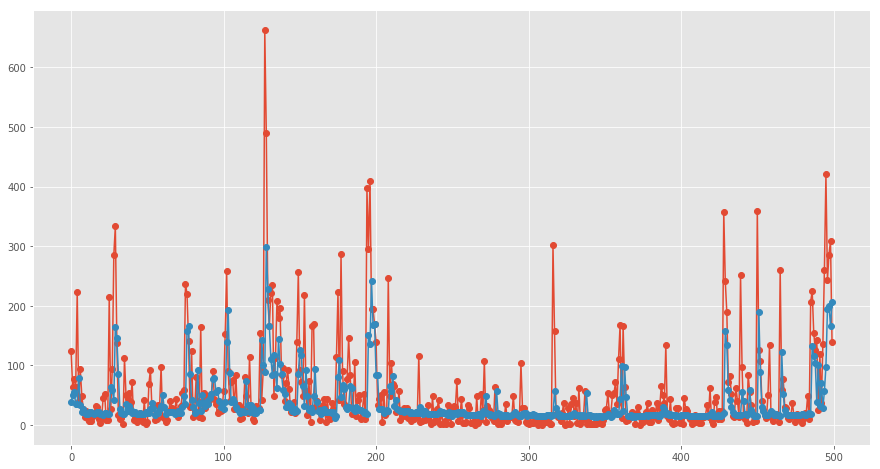

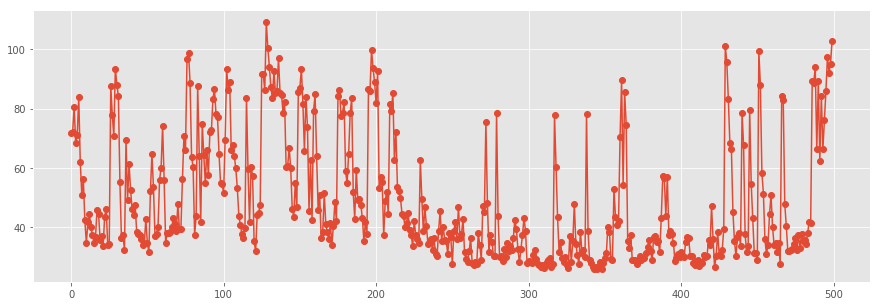

In [30]:

path_res = "../results/mixture_tar5_len10_ensemble_llk/"

py = pickle.load(open(path_res + "py_gaussian_lk_inv_none_none" + ".p", "rb"), \
                     encoding='latin1')


plot_l = 0
plot_r = 500

#   -- mean  
fig, ax = plt.subplots(figsize=(15,8));
    
ax.plot(range(plot_l, plot_r), ts_y[plot_l: plot_r], label = 'truth',  marker='o');
ax.plot(range(plot_l, plot_r), py[0][plot_l: plot_r], label = 'prediction',  marker='o');
    
# ax.set_title(plot_title)
# ax.legend()
    
#   -- variance
fig, ax = plt.subplots(figsize=(15,5));
    
ax.plot(range(plot_l, plot_r), np.sqrt(py[1])[plot_l: plot_r], label = 'volatility',  marker='o');
    
# ax.set_title(plot_title)
# ax.legend()

In [4]:

gaussian_lk_inv = ["py_gaussian_lk_inv_none_none",  
      "py_gaussian_lk_inv_independent_none",
      "py_gaussian_lk_inv_markov_constant_diff_sq",
      "py_gaussian_lk_inv_markov_scalar_diff_sq",
      "py_gaussian_lk_inv_markov_vector_diff_sq",
      "py_gaussian_lk_inv_markov_pos_neg_diff_sq"]


gaussian_lk = ["py_gaussian_lk_none_none",
      "py_gaussian_lk_independent_none",
      "py_gaussian_lk_markov_constant_diff_sq",
      "py_gaussian_lk_markov_scalar_diff_sq",
      "py_gaussian_lk_markov_vector_diff_sq",
      "py_gaussian_lk_markov_pos_neg_diff_sq"
     ]


path_data = "../dataset/bitcoin/double_trx_ob_tar1_len10/"

ts_dta = pickle.load(open(path_data + 'test.p', "rb"), encoding = 'latin1')
    
ts_x, ts_y = data_reshape(ts_dta,
                          bool_target_seperate = False)

fig, ax = plt.subplots();

ax.hist(ts_y, 2000);
ax.set_xlim([-10, 50]);
ax.set_title("True values");

src 0 :  (34346, 10, 7)
src 1 :  (34346, 10, 7)
src 2 :  (34346, 10, 10)



 --------  py_gaussian_lk_inv_none_none
(34346, 1)
MAE 8.686509783529049
RMSE 22.758746530306702
Quantiles [0.09125508, 0.33173101, 0.7838064100000001, 1.40505704, 2.38401153, 3.95315725, 6.58127803, 11.668147089999994, 25.503929119999995, 510.05139949] 

  RMSE [8.52314004836259, 12.1105526081563, 6.173103880841695, 9.622343362592355, 3.414511393622627, 3.107724431085796, 6.382270714335346, 8.884780830011639, 13.729402243876656, 67.031460389255]
  MAE [3.2454014563673197, 3.277956873679283, 3.027906866766979, 2.8354661866424413, 2.0929456689869568, 1.5019078298441695, 2.099396174925982, 4.692058018038357, 12.023682001537665, 51.99490799268706]
  MAPE [284.0038126229513, 18.610519386458947, 6.025158745406477, 2.7346739951348407, 1.1612546180445087, 0.49908938227967325, 0.40793596128085435, 0.5219211523513062, 0.6807980250788258, 0.826740025372226]

 --------  py_gaussian_lk_inv_independent_none
(34346, 1)
MAE 8.515889831375736
RMSE 22.314909495429074
Quantiles [0.09125508, 0.33173101,

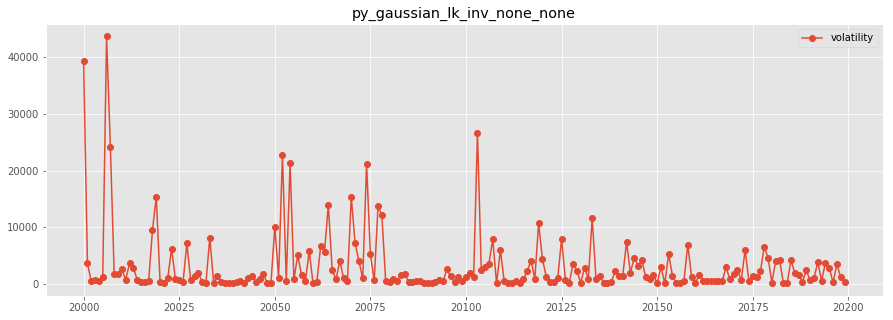

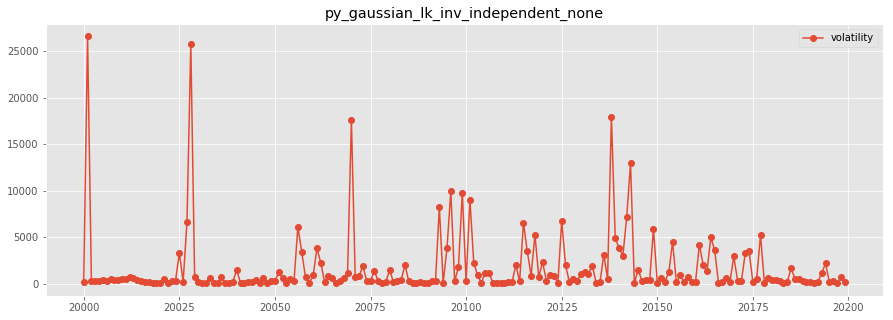

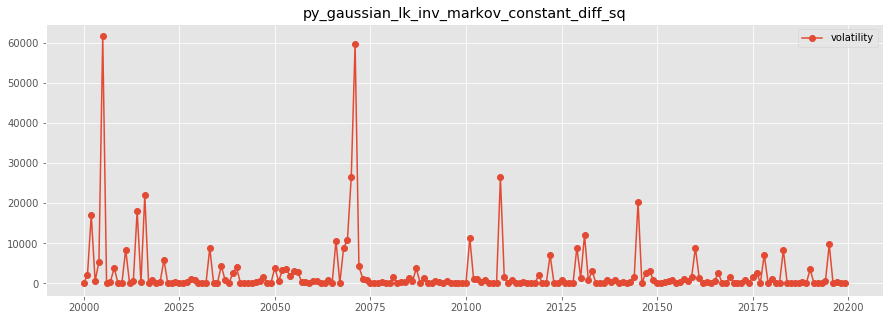

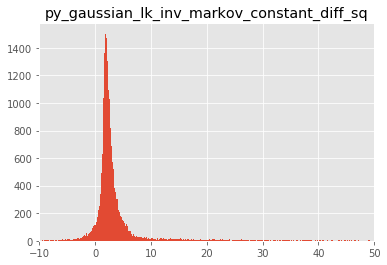

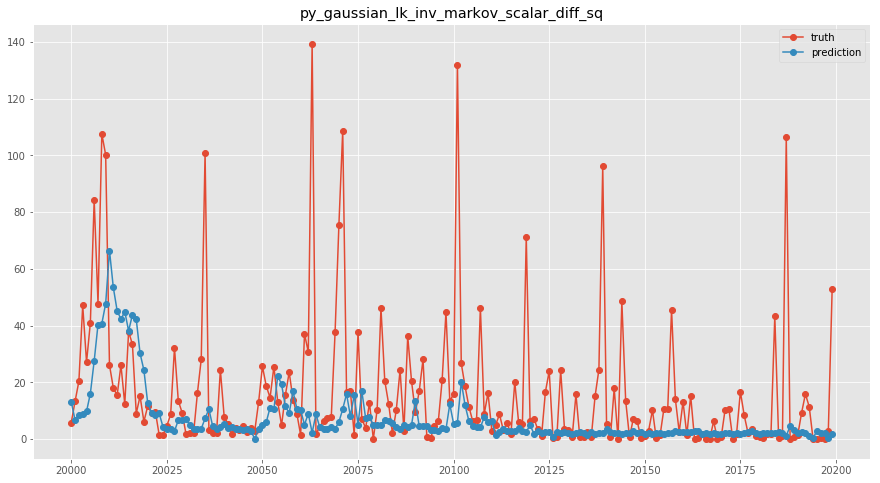

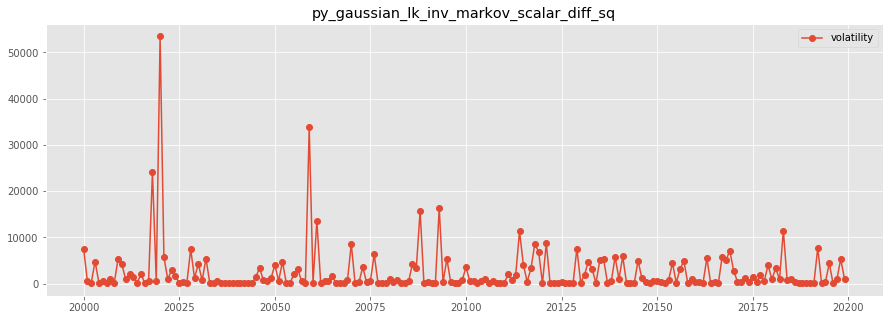

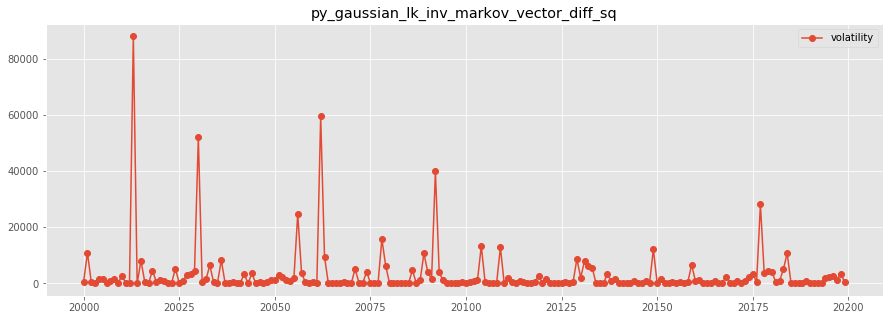

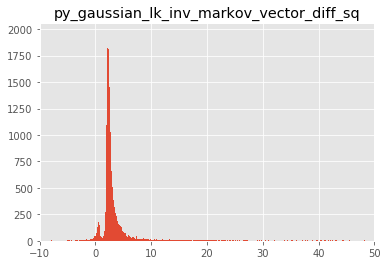

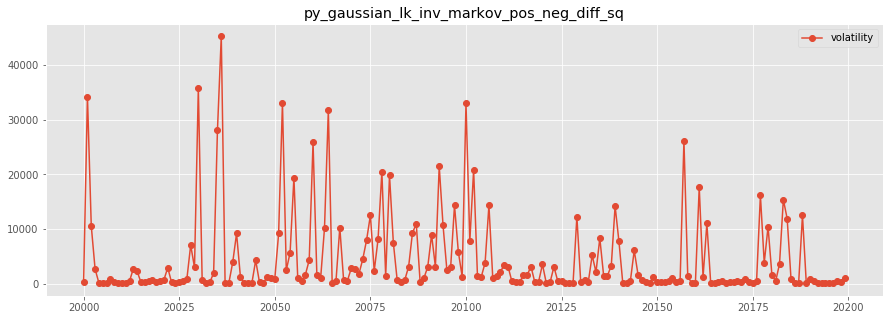

In [20]:
plot_l = 20000
plot_r = 20200

path_res = "../results/mixture_gc_py_src_tar_1min/" 

for tmp_path in gaussian_lk_inv:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)


 --------  py_gaussian_lk_inv_none_none
(34346, 1)
MAE 8.686509783529049
RMSE 22.758746530306702
Quantiles [0.09125508, 0.33173101, 0.7838064100000001, 1.40505704, 2.38401153, 3.95315725, 6.58127803, 11.668147089999994, 25.503929119999995, 510.05139949] 

  RMSE [8.52314004836259, 12.1105526081563, 6.173103880841695, 9.622343362592355, 3.414511393622627, 3.107724431085796, 6.382270714335346, 8.884780830011639, 13.729402243876656, 67.031460389255]
  MAE [3.2454014563673197, 3.277956873679283, 3.027906866766979, 2.8354661866424413, 2.0929456689869568, 1.5019078298441695, 2.099396174925982, 4.692058018038357, 12.023682001537665, 51.99490799268706]
  MAPE [284.0038126229513, 18.610519386458947, 6.025158745406477, 2.7346739951348407, 1.1612546180445087, 0.49908938227967325, 0.40793596128085435, 0.5219211523513062, 0.6807980250788258, 0.826740025372226]

 --------  py_gaussian_lk_inv_independent_none
(34346, 1)
MAE 8.515889831375736
RMSE 22.314909495429074
Quantiles [0.09125508, 0.33173101,

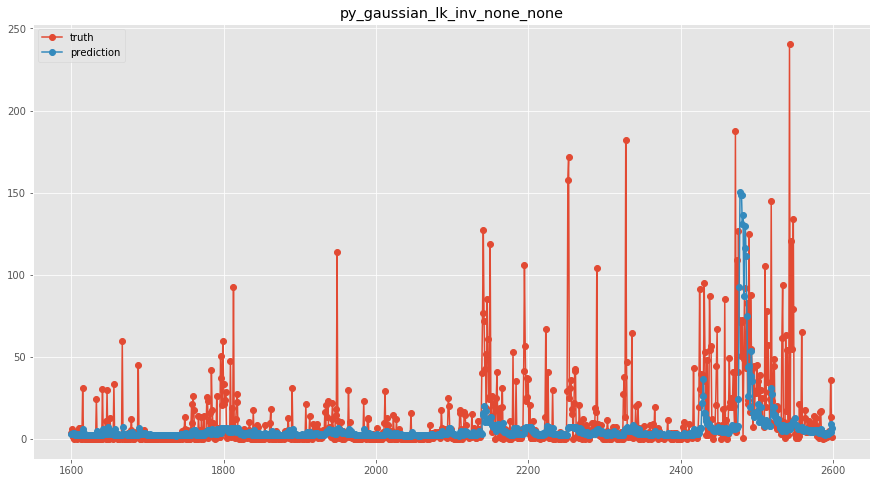

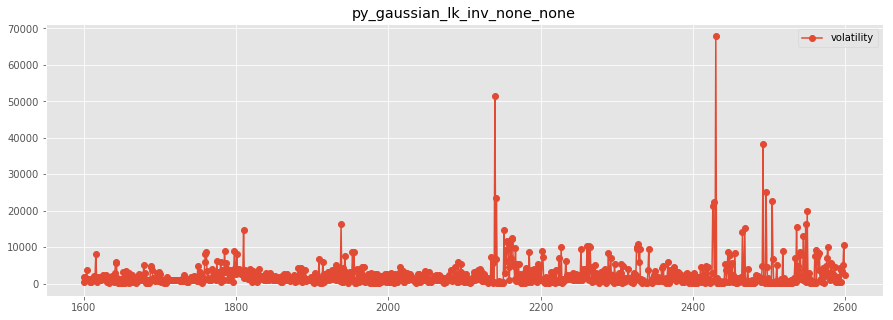

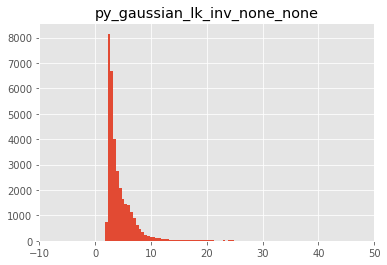

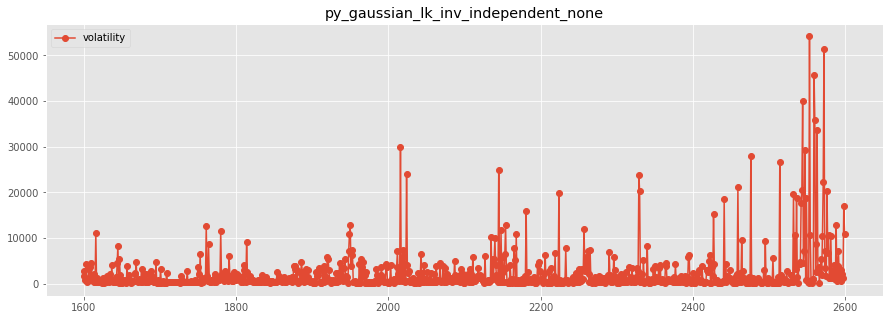

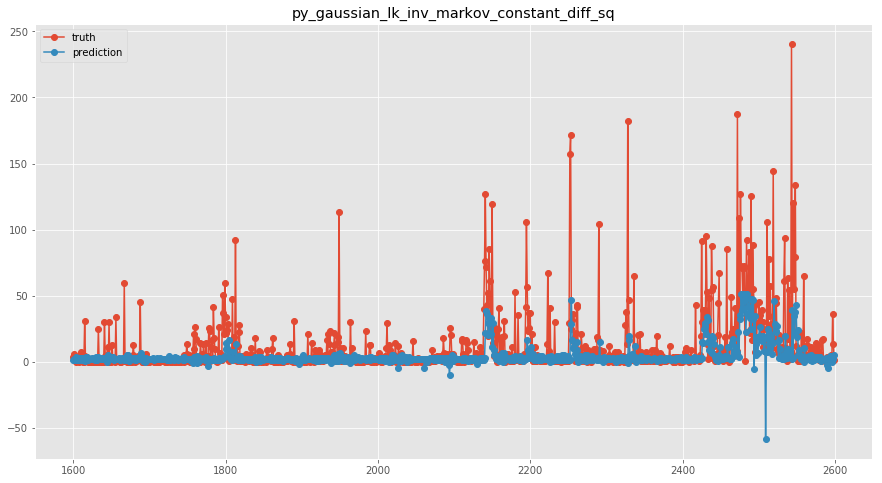

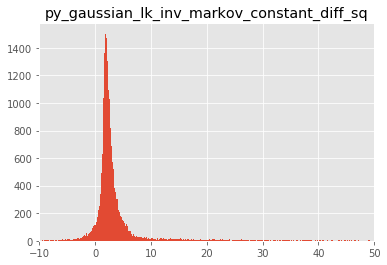

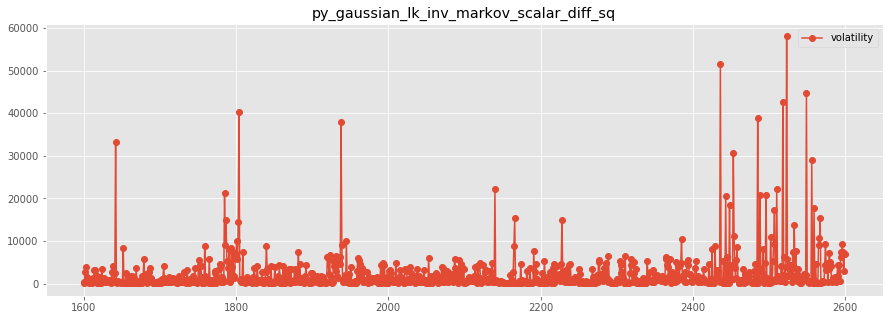

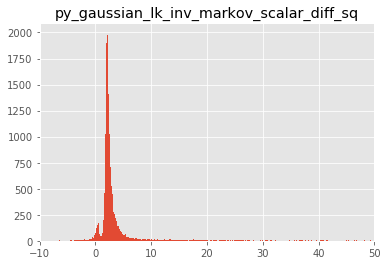

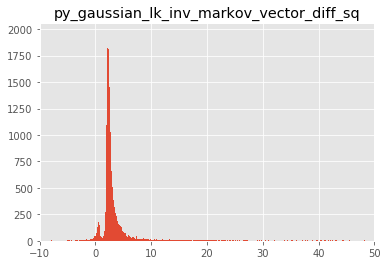

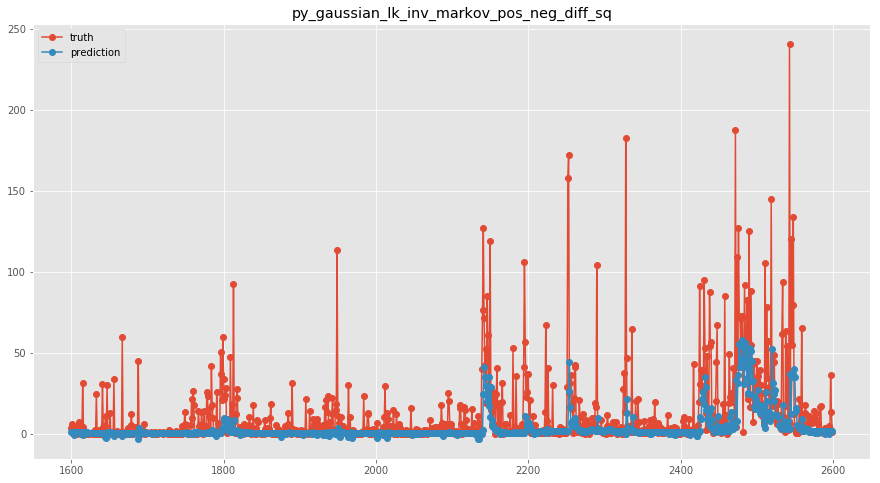

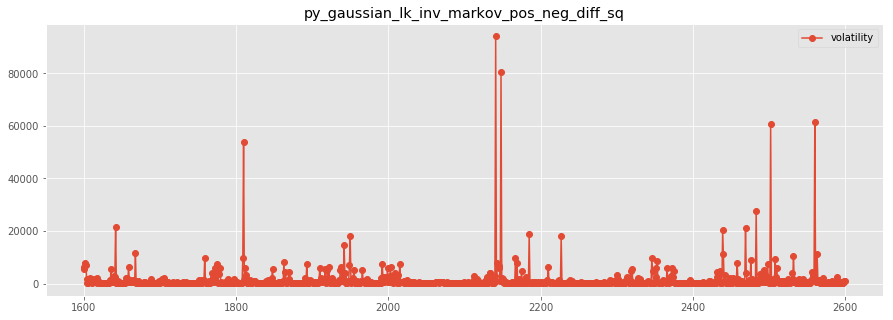

In [17]:
plot_l = 1600
plot_r = 2600

path_res = "../results/mixture_gc_py_tar_1min/" 

for tmp_path in gaussian_lk_inv:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)


 --------  py_gaussian_lk_none_none
(34346, 1)
(2, 34346, 1)
MAE 9.14789687246628
RMSE 23.519686590581625
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [4.385521434204369, 2.844849599134336, 4.55438840049908, 46.524244513123485]
  MAE [2.5836135436006638, 1.7010120432044635, 2.294050407561212, 30.010736676311566]

 --------  py_gaussian_lk_independent_none
(34346, 1)
(2, 34346, 1)
MAE 8.484322496447227
RMSE 22.384411288616455
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [4.444580738196734, 7.2703906181263465, 10.359542857555082, 42.71065294362603]
  MAE [2.5391808664260975, 1.8676070800018374, 2.67127390629613, 26.856594872682546]

 --------  py_gaussian_lk_markov_constant_diff_sq
(34346, 1)
(2, 34346, 1)
MAE 8.854847704607298
RMSE 21.778826077036058
Quantiles [0.52821867, 2.38473488, 8.76078398, 510.05139949]
  RMSE [2.809519619260736, 3.576182269990516, 6.984950147181116, 42.75134901457726]
  MAE [2.2856300789486146, 1.7730070033687557, 3

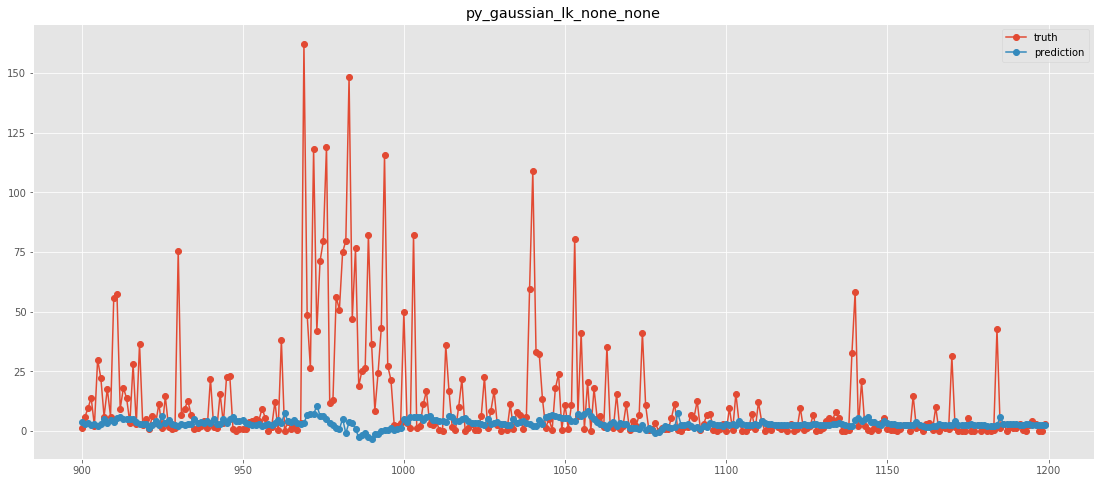

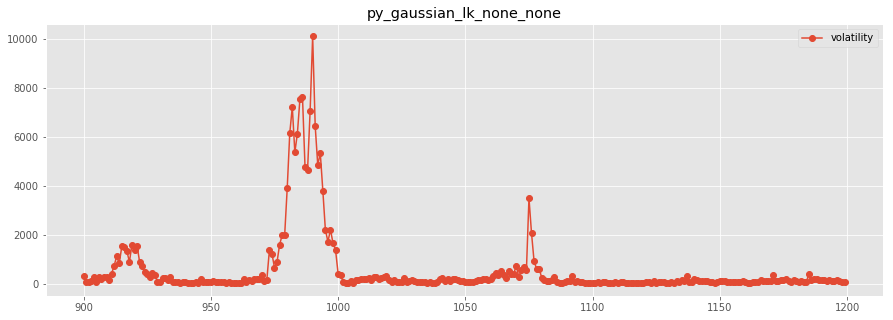

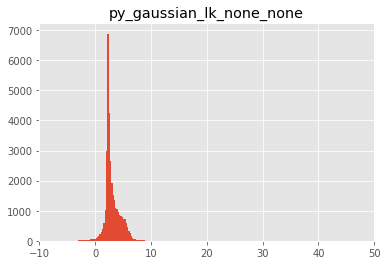

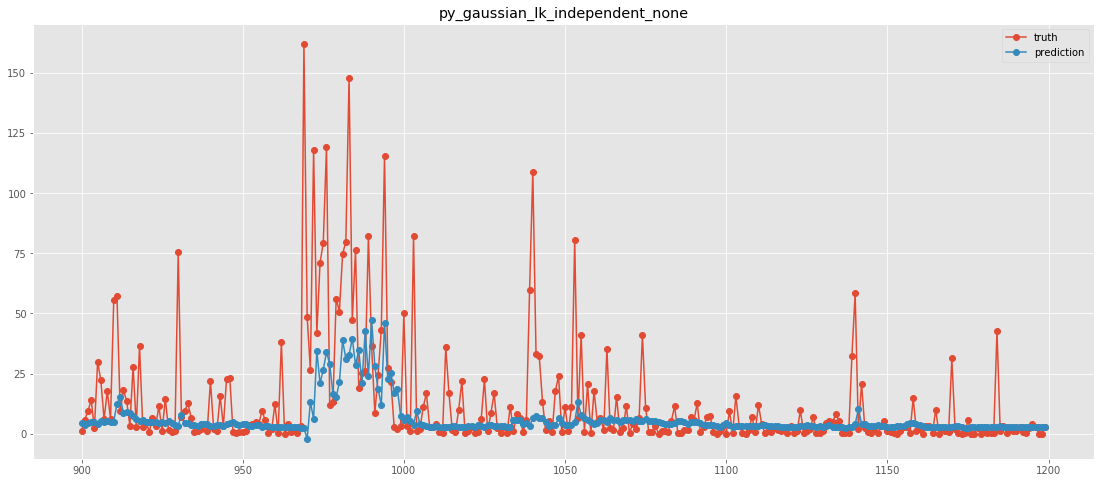

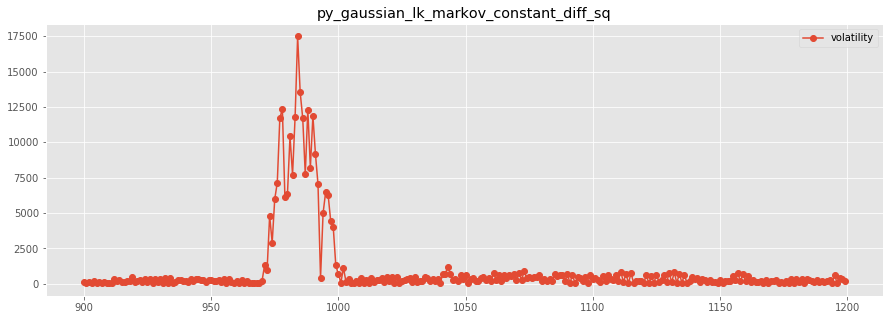

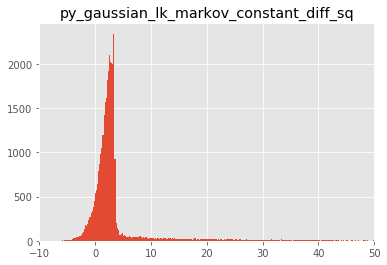

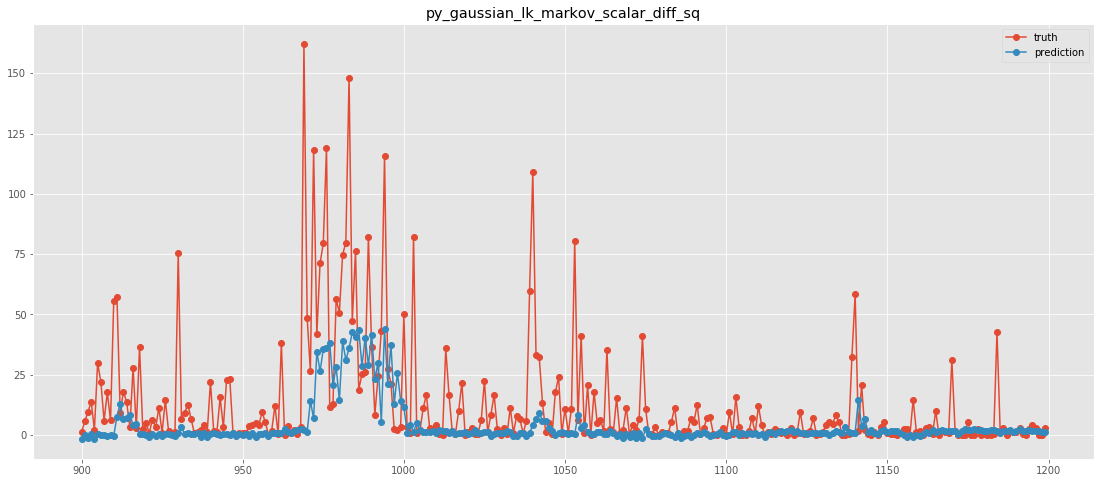

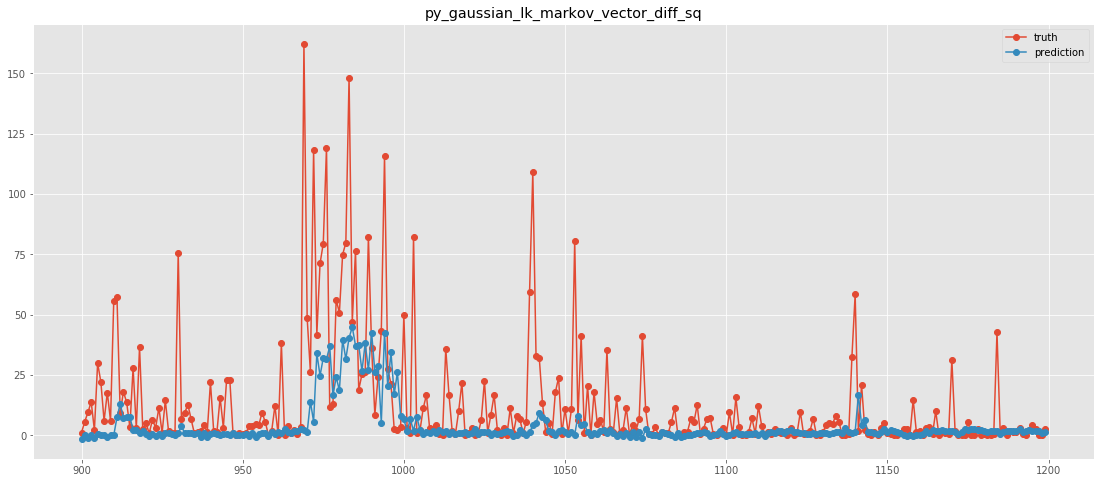

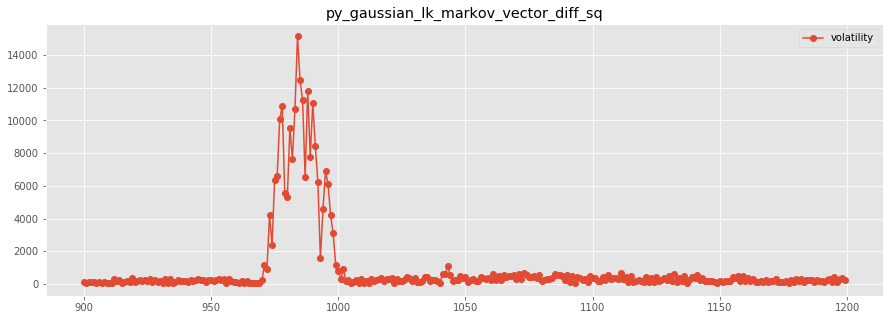

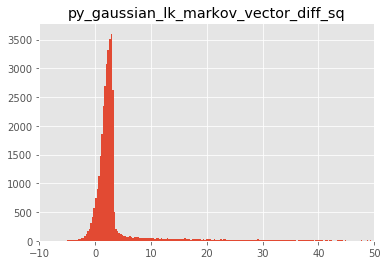

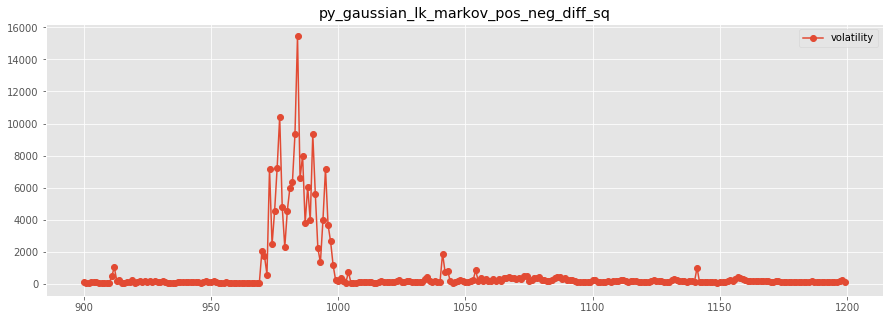

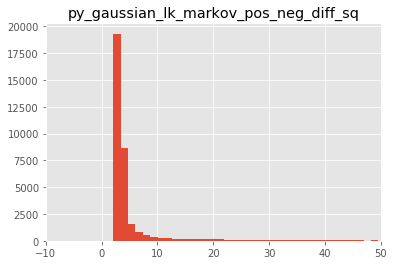

In [12]:

for tmp_path in gaussian_lk:
    
    print("\n -------- ", tmp_path)
    
    result_plot(ts_y, 
                path_res + tmp_path, 
                plot_l, 
                plot_r, 
                tmp_path)